In [2]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

In [3]:
data_dir = '../logs/Atari/'
data_files = os.listdir(data_dir)
data = list()
labels = list()

fmt = '{:<20}{}'

for i, file in enumerate(data_files):
    if 'eval' not in file:
        with open(data_dir + file, 'r') as f:
            data.append(f.readlines()[1:])
        if 'wm' in file:
            lab = 'wm ' + file.split('_')[-1].split('.')[0]
        elif 'dqn' in file:
            lab = 'dqn ' + file.split('-')[-2].lower()
        labels.append(lab)
        
print('Lines per dataset:')
for i in range(len(data)):
    print(fmt.format(labels[i], len(data[i])))

Lines per dataset:
dqn frostbite       129090
dqn spaceinvaders   40902
wm pong             43350
dqn pong            20034
wm spaceinvaders    35022
wm mspacman         36798
wm frostbite        41304
dqn mspacman        61320


In [4]:
def chunk(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

chunked_data = list()

print('Episodes per dataset:')
for i, ds in enumerate(data):
    if 'random' in labels[i].lower():
        chunk_size = 5
    else:
        chunk_size = 6
    chunked_data.append(list(chunk(ds, chunk_size)))
    
    print(fmt.format(labels[i], len(chunked_data[i])))

Episodes per dataset:
dqn frostbite       21515
dqn spaceinvaders   6817
wm pong             7225
dqn pong            3339
wm spaceinvaders    5837
wm mspacman         6133
wm frostbite        6884
dqn mspacman        10220


In [7]:
seperator = '-'*114
avg_rewards = dict()

conv_rate = 0.001

for i, chunked_ds in enumerate(chunked_data):
    print(f'{seperator}\n{labels[i]}\n{seperator}')
    
    last = list()
    conv_count = 0
    conv_place = 0
    for j, epi in enumerate(chunked_ds):
        if abs(float(epi[4].strip().split(': ')[1])) < conv_rate and j > 5000:
            last.append(epi[4].strip().split(': ')[1])
            conv_count += 1
        else:
            last = list()
            conv_count = 0
            
        if conv_count == 5:
            conv_place = j
            break
            
    if conv_place == 0:
        conv_place = j
    
    avg_rew = [float(epi[3].strip().split(': ')[1]) for epi in chunked_ds]    
    print('\n' + str(stats.describe(avg_rew[:conv_place-1])))
    print('\n' + str(np.std(avg_rew[:conv_place-1])))
    print('\nEpisode where max avg reward occurred:\n' + \
          ''.join(chunked_ds[np.argmax(avg_rew[:conv_place-1])]))
    
    print(len(avg_rew), conv_place)
    print(last)
    print(avg_rew[-1])
    
    avg_rewards[labels[i]] = avg_rew[:conv_place-1]

------------------------------------------------------------------------------------------------------------------
dqn frostbite
------------------------------------------------------------------------------------------------------------------

DescribeResult(nobs=21513, minmax=(0.0, 277.9876261803973), mean=256.5499743158063, variance=1264.8901559935985, skewness=-3.3599816409587477, kurtosis=11.804878187979849)

35.56446765304833

Episode where max avg reward occurred:
06/04/2020 02:11:36 - Episode 3072:               
	latest episode reward: 220.0               
	total episode reward: 853920.0               
	average_reward: 277.9876261803973               
	change in average: 0.18306591981098563               
	average Q_loss: 0.08054912817010529

21515 21514
[]
277.21006207121854
------------------------------------------------------------------------------------------------------------------
dqn spaceinvaders
-----------------------------------------------------------------------

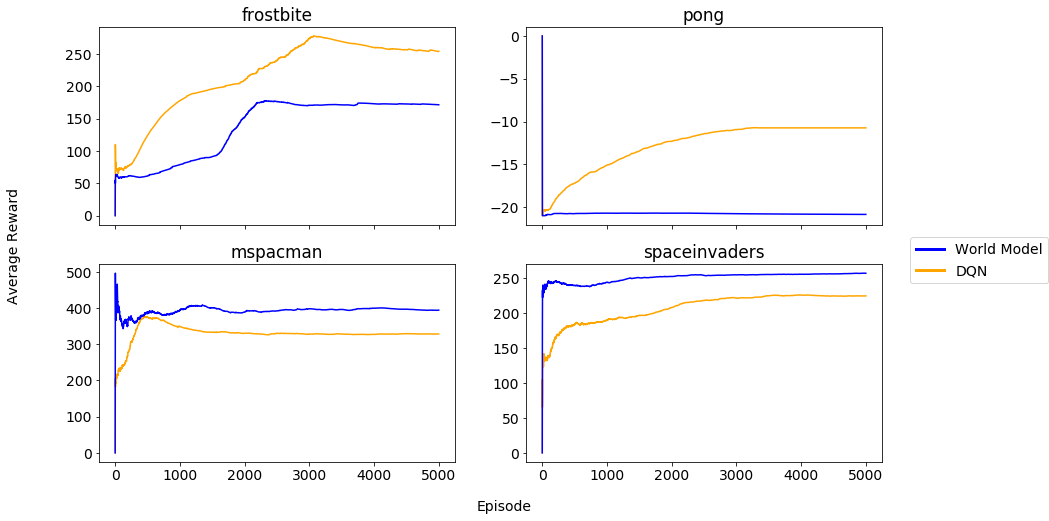

In [60]:
font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

limit = 5000

lower_bound = -float('INF')
upper_bound = float('INF')

from copy import deepcopy
def pad(dataset, length):
    ds = deepcopy(dataset)
    while len(ds) < length:
        ds.append(ds[-1])
    
    return ds

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)

frostbite = (ax1, [(label, dataset) for (label, dataset) in avg_rewards.items() if 'frostbite' in label])
pong = (ax2, [(label, dataset) for (label, dataset) in avg_rewards.items() if 'pong' in label])
mspacman = (ax3, [(label, dataset) for (label, dataset) in avg_rewards.items() if 'mspacman' in label])
spaceinvaders = (ax4, [(label, dataset) for (label, dataset) in avg_rewards.items() if 'spaceinvaders' in label])
datasets = (frostbite, pong, mspacman, spaceinvaders)

    
for (ax, ds) in datasets:
    for (label, dataset) in ds:
        clip = np.clip(pad(dataset[:limit], limit), lower_bound, upper_bound)
        if 'wm' in label:
            color = 'blue'
        elif 'dqn' in label:
            color = 'orange'
        ax.plot(clip, color=color, label=label)
        ax.set_title(label.split()[-1])
        
fig.text(0.5, 0.04, 'Episode', ha='center')
fig.text(0.04, 0.5, 'Average Reward', va='center', rotation='vertical')
plt.subplots_adjust(right=0.85)

# # Put a legend below current axis
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='orange', lw=3)]
fig.legend(custom_lines, ('World Model', 'DQN'), 
           loc='center right', ncol=1, borderaxespad=0.1)